In [1]:
import cached
import cpr_gym
import git
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import psutil
import seaborn as sns
import threadpoolctl
import time
import torch
import warnings
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

tqdm.pandas()
torch.set_num_threads = 1

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
os.chdir(repo.working_tree_dir)

cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = aft23-25-g05f4844 (engine: aft23-20-g21e8f79-dirty)
cpr_lib_version: aft23-20-g21e8f79-dirty


In [2]:
episode_len = 2048
n_episodes = 100
batches = [
    "2023-10-31_dag-voting-2",
    "2023-11-01_dag-voting-4",
    "2023-11-02_dag-voting-5",
    "2023-11-03_dag-voting-6",
    "2023-11-05_dag-voting-7",
]

protocol_args = dict(
    nakamoto=[],
    bk=["k", "reward"],
    tailstorm=["k", "reward", "subblock_selection"],
    tailstormjune=["k", "reward"],
    spar=["k", "reward"],
    stree=["k", "reward", "subblock_selection"],
    sdag=["k", "reward", "subblock_selection"],
)

env_name = "cpr_gym:cpr-v0"


def env_kwargs_of_row(x):
    return dict(
        protocol=x.protocol,
        protocol_args={k: x[k] for k in protocol_args[x.protocol]},
        alpha=x.alpha if "alpha" in x.keys() else 0,
        gamma=x.gamma if "gamma" in x.keys() else 0,
        defenders=42,
    )

# Data generation

## Find trained models

In [3]:
def models():
    for batch in batches:
        for m in pathlib.Path(f"data/models/{batch}").glob("ppo-*.zip"):
            frag = m.stem.split("-")
            protocol = frag.pop(1)

            ent_coef = 0
            for i, x in enumerate(frag):
                if x.startswith("entcoef"):
                    ent_coef = float(x.removeprefix("entcoef"))
                    frag.pop(i)

            learning_rate = "linear:1e-3"
            for i, x in enumerate(frag):
                if x.startswith("lr"):
                    learning_rate = x.removeprefix("lr")
                    frag.pop(i)

            shape = "raw"
            for i, x in enumerate(frag):
                if x in ["raw", "exp", "cut"]:
                    shape = x
                    frag.pop(i)

            if protocol == "nakamoto":
                yield dict(
                    protocol=protocol,
                    k=1,
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    batch=batch,
                    learning_rate=learning_rate,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["bk", "spar"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    batch=batch,
                    learning_rate=learning_rate,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["tailstorm", "stree", "sdag"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward=frag.pop(1),
                    subblock_selection="heuristic",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    batch=batch,
                    learning_rate=learning_rate,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            else:
                raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models()).assign(kind="trained", reuse="-")
models

,protocol,k,reward,subblock_selection,alpha,gamma,batch,learning_rate,ent_coef,shape,policy,path,kind,reuse
0,nakamoto,1,constant,n/a,0.40,0.05,2023-10-31_dag-voting-2,0.0001,0.010,raw,ppo-z9vbrhj9-best,data/models/2023-10-31_dag-voting-2/ppo-nakamo...,trained,-
1,nakamoto,1,constant,n/a,0.40,0.05,2023-10-31_dag-voting-2,0.0003,0.010,raw,ppo-19vvmn15-best,data/models/2023-10-31_dag-voting-2/ppo-nakamo...,trained,-
2,nakamoto,1,constant,n/a,0.25,0.05,2023-10-31_dag-voting-2,0.0001,0.010,raw,ppo-th8qq11a-last,data/models/2023-10-31_dag-voting-2/ppo-nakamo...,trained,-
3,nakamoto,1,constant,n/a,0.25,0.05,2023-10-31_dag-voting-2,0.0003,0.010,raw,ppo-9ceplcuq-last,data/models/2023-10-31_dag-voting-2/ppo-nakamo...,trained,-
4,nakamoto,1,constant,n/a,0.45,0.05,2023-10-31_dag-voting-2,0.0003,0.010,raw,ppo-1bbi1v3z-last,data/models/2023-10-31_dag-voting-2/ppo-nakamo...,trained,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,tailstorm,4,discount,heuristic,0.40,0.50,2023-11-05_dag-voting-7,0.0003,0.001,raw,ppo-k8xq3z03-best,data/models/2023-11-05_dag-voting-7/ppo-tailst...,trained,-
442,sdag,4,constant,heuristic,0.40,0.50,2023-11-05_dag-voting-7,0.0003,0.010,raw,ppo-tys87376-best,data/models/2023-11-05_dag-voting-7/ppo-sdag-4...,trained,-
443,stree,4,discount,heuristic,0.40,0.50,2023-11-05_dag-voting-7,0.0003,0.001,raw,ppo-o3w8zp04-last,data/models/2023-11-05_dag-voting-7/ppo-stree-...,trained,-
444,stree,4,constant,heuristic,0.40,0.50,2023-11-05_dag-voting-7,0.0003,0.005,raw,ppo-asl91y3l-best,data/models/2023-11-05_dag-voting-7/ppo-stree-...,trained,-


In [4]:
# reuse some trained models for other settings
models = pd.concat(
    [
        models,
        # models.query('protocol == "tailstorm" and reward == "constant"').assign(
        #     reuse="proto", reward="discount"
        # ),
        models.query("gamma != 0.05").assign(reuse="gamma05", gamma=0.05),
        models.query("gamma != 0.50").assign(reuse="gamma50", gamma=0.50),
        models.query("gamma != 0.95").assign(reuse="gamma95", gamma=0.95),
    ]
)
models = models.assign(reused=[x != "-" for x in models.reuse])
# models

## Find hard-coded policies

In [5]:
def hard_coded_policies(models):
    for _idx, x in (
        models[["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]]
        .drop_duplicates()
        .iterrows()
    ):
        kwargs = env_kwargs_of_row(x)
        env = gym.make(env_name, **kwargs)
        for p in env.policies():
            x = x.copy()
            x["policy"] = p
            yield x


hard_coded_policies = (
    pd.DataFrame(hard_coded_policies(models))
    .reset_index(drop=True)
    .assign(kind="hard-coded", path="n/a", reuse="-", reused=False)
    .query('protocol != "nakamoto" or (policy in ["sapirshtein-2016-sm1", "honest"])')
    .query("policy != 'avoid-loss'")
)

hard_coded_policies
# hard_coded_policies.drop(columns=["alpha", "gamma"]).drop_duplicates()

,protocol,k,reward,subblock_selection,gamma,alpha,policy,kind,path,reuse,reused
0,nakamoto,1,constant,n/a,0.05,0.40,sapirshtein-2016-sm1,hard-coded,n/a,-,False
3,nakamoto,1,constant,n/a,0.05,0.40,honest,hard-coded,n/a,-,False
4,nakamoto,1,constant,n/a,0.05,0.25,sapirshtein-2016-sm1,hard-coded,n/a,-,False
7,nakamoto,1,constant,n/a,0.05,0.25,honest,hard-coded,n/a,-,False
8,nakamoto,1,constant,n/a,0.05,0.45,sapirshtein-2016-sm1,hard-coded,n/a,-,False
...,...,...,...,...,...,...,...,...,...,...,...
388,stree,4,constant,heuristic,0.95,0.40,minor-delay,hard-coded,n/a,-,False
389,stree,4,constant,heuristic,0.95,0.40,override-catchup,hard-coded,n/a,-,False
390,stree,4,constant,heuristic,0.95,0.40,override-block,hard-coded,n/a,-,False
391,stree,4,constant,heuristic,0.95,0.40,release-block,hard-coded,n/a,-,False


## Run simulations

In [6]:
models_and_hard_coded_policies = pd.concat(
    [models, hard_coded_policies], ignore_index=True
)


def episodes():
    for i in range(0, n_episodes):
        yield models_and_hard_coded_policies.assign(episode=i)


episodes = pd.concat(episodes(), ignore_index=True)

In [7]:
def measure_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = episode_len
    kwargs["seed"] = getattr(x, "episode", None)
    if x.kind == "trained":
        with warnings.catch_warnings():
            warnings.filterwarnings(
                action="ignore", category=UserWarning, lineno=458
            )  # transition to sb3 v1.7
            res = cached.measure_trained(env_name, x.path, **kwargs)
    elif x.kind == "hard-coded":
        res = cached.measure_hardcoded(env_name, x.policy, **kwargs)
    else:
        assert False
    return pd.Series(res)


def parallel_measure(df, fun=measure_row, n_jobs=-1):
    res = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(fun)(row) for idx, row in tqdm(df.iterrows(), total=len(df))
    )
    return pd.concat([df, pd.DataFrame(res)], axis=1)


episodes = parallel_measure(episodes)

# list(episodes.columns)

  0%|          | 0/165600 [00:00<?, ?it/s]

In [8]:
# save episode data for re-use in other notebooks
episodes.to_pickle("experiments/rl-eval/episodes.pkl")

# Find optimal policies

In [9]:
scenario = [
    "protocol",
    "k",
    "reward",
    "subblock_selection",
    "alpha",
    "gamma",
    "kind",
    "reused",
]
policy = ["policy", "path"]
# d = episodes.query("kind=='hard-coded'")
d = episodes
opt_means = (
    d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
    .groupby(scenario + policy, as_index=False)
    .episode_reward.mean()
)
opt_policies = (
    opt_means.loc[opt_means.groupby(scenario).episode_reward.idxmax()]
    .drop(columns=["episode_reward"])
    .reset_index(drop=True)
)
display(opt_policies.drop(columns=["path"]))

opt_episodes = opt_policies.join(d.set_index(scenario + policy), on=scenario + policy)
# display("opt_episodes columns", list(opt_episodes.columns))

,protocol,k,reward,subblock_selection,alpha,gamma,kind,reused,policy
0,nakamoto,1,constant,n/a,0.25,0.05,hard-coded,False,honest
1,nakamoto,1,constant,n/a,0.25,0.05,trained,False,ppo-th8qq11a-last
2,nakamoto,1,constant,n/a,0.25,0.05,trained,True,ppo-zzv4kwk4-best
3,nakamoto,1,constant,n/a,0.25,0.50,hard-coded,False,sapirshtein-2016-sm1
4,nakamoto,1,constant,n/a,0.25,0.50,trained,False,ppo-w31khco1-best
...,...,...,...,...,...,...,...,...,...
217,tailstorm,4,discount,heuristic,0.40,0.05,trained,True,ppo-k8xq3z03-last
218,tailstorm,4,discount,heuristic,0.40,0.50,hard-coded,False,minor-delay
219,tailstorm,4,discount,heuristic,0.40,0.50,trained,False,ppo-np5a16jn-best
220,tailstorm,4,discount,heuristic,0.40,0.95,hard-coded,False,minor-delay


# Compare RL against best hard-coded

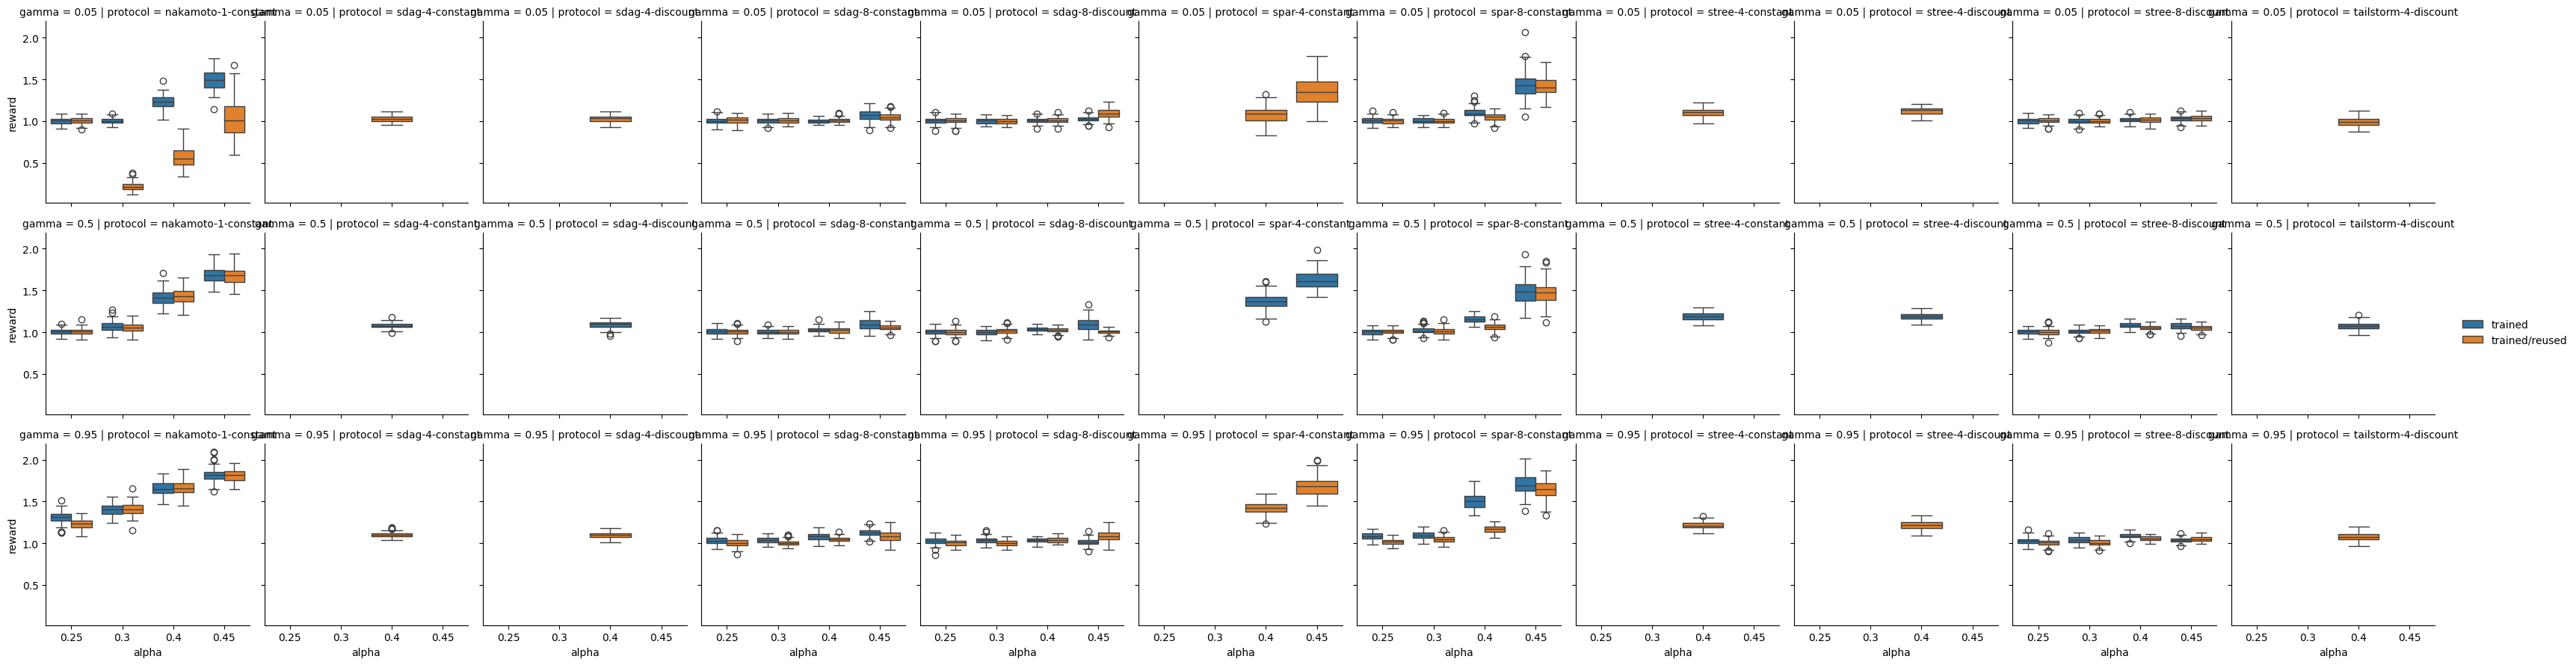

In [10]:
def rl_vs_hard_coded_bp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = d.query('kind != "hard-coded"')
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.FacetGrid(
        data=d,
        # data=d.query("alpha >= .35"),
        col="protocol",
        row="gamma",
        sharex=True,
        sharey=True,
    )
    g.map_dataframe(
        sns.boxplot,
        x="alpha",
        y=label,
        hue="kind",
        orient="v",
        palette="tab10",
    )
    g.add_legend()


## reward per progess (in DAA equilibrium)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress)
## alpha normalizations
rl_vs_hard_coded_bp(lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress - d.alpha)

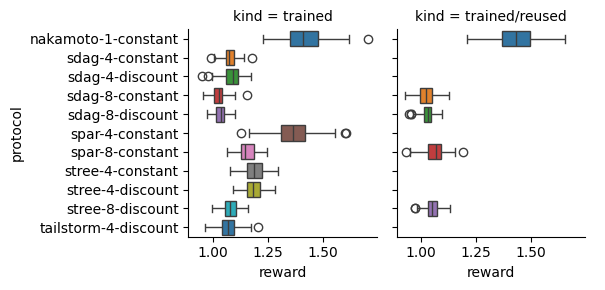

In [16]:
def rl_vs_hard_coded_bp_zoom(objective, gamma=0.5, alpha=0.4, label="reward"):
    d = opt_episodes.query(f"alpha == {alpha} and gamma == {gamma}")
    d.loc[d.reused, "kind"] = "trained/reused"
    d = d.query('kind != "hard-coded"')
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.FacetGrid(
        data=d,
        # data=d.query("alpha >= .35"),
        col="kind",
        sharex=True,
        sharey=True,
    )
    g.map_dataframe(
        sns.boxplot,
        y="protocol",
        x=label,
        hue="protocol",
        orient="h",
        palette="tab10",
    )
    g.add_legend()


## reward per progess (in DAA equilibrium)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress)
## alpha normalizations
rl_vs_hard_coded_bp_zoom(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress - d.alpha)

In [11]:
opt_policies.query('protocol == "stree" and gamma==0.95 and alpha==.45').drop(
    columns=["path"]
)

,protocol,k,reward,subblock_selection,alpha,gamma,kind,reused,policy
213,stree,8,discount,heuristic,0.45,0.95,hard-coded,False,honest
214,stree,8,discount,heuristic,0.45,0.95,trained,False,ppo-u4zb7a3r-best
215,stree,8,discount,heuristic,0.45,0.95,trained,True,ppo-zx56y75g-best


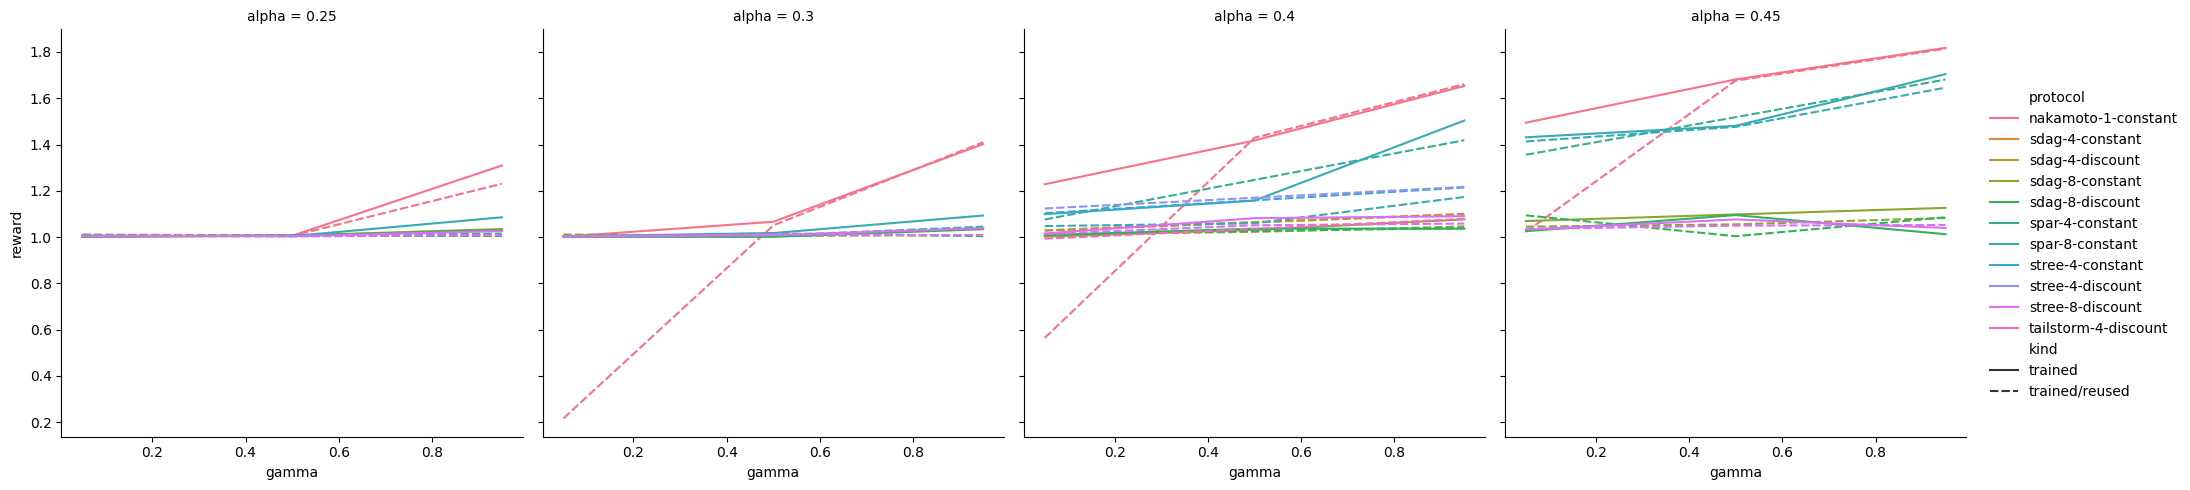

In [12]:
def rl_vs_hard_coded_gamma_lp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = d.query('kind != "hard-coded"')
    d = (
        d.assign(__=objective)
        .groupby(
            [
                "protocol",
                "k",
                "reward",
                "subblock_selection",
                "alpha",
                "gamma",
                "kind",
                "reused",
                "policy",
            ]
        )["__"]
        .mean()
        .reset_index()
        .assign(
            protocol=lambda d: d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=lambda d: d.kind.astype("category"),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )

    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="alpha",
        x="gamma",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_gamma_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

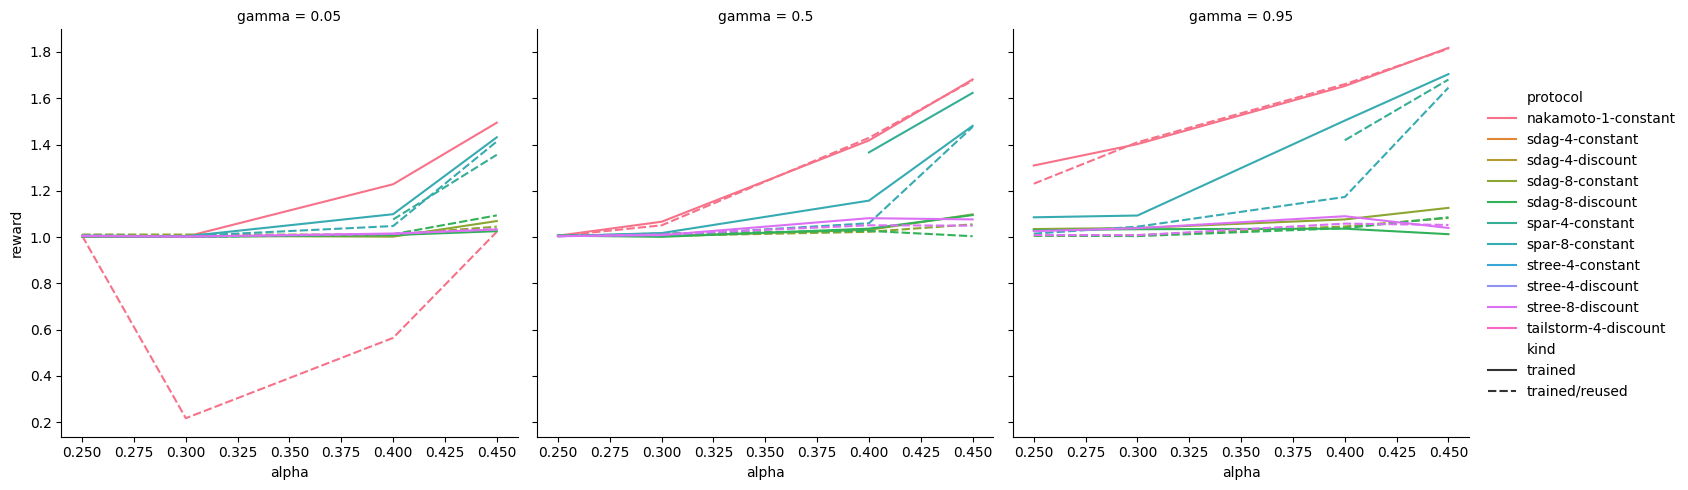

In [13]:
def rl_vs_hard_coded_alpha_lp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = d.query('kind != "hard-coded"')
    d = (
        d.assign(__=objective)
        .groupby(
            [
                "protocol",
                "k",
                "reward",
                "subblock_selection",
                "alpha",
                "gamma",
                "kind",
                "reused",
                "policy",
            ]
        )["__"]
        .mean()
        .reset_index()
        .assign(
            protocol=lambda d: d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=lambda d: d.kind.astype("category"),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )

    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="gamma",
        x="alpha",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_alpha_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)